<a href="https://colab.research.google.com/github/Sid-Oya/DS-Unit-2-Kaggle-Challenge/blob/master/Sidoney_Daley_DS_Unit2_Sprint2_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [ ]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



In [ ]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [ ]:
df['game_date'].describe()

count          13958
unique           801
top       2013-05-06
freq              35
Name: game_date, dtype: object

In [ ]:
df['game_date'] = df['game_date'].astype('datetime64[ns]')
df.sort_values(by='game_date')

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13928,41800403,15,Stephen Curry,1,11,16,Fadeaway Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16,161,20,1,2019-06-05,GSW,TOR,Playoffs,-2.0
13927,41800403,7,Stephen Curry,1,11,45,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,192,179,0,2019-06-05,GSW,TOR,Playoffs,0.0
13956,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,2019-06-05,GSW,TOR,Playoffs,-16.0
13941,41800403,377,Stephen Curry,3,9,19,Cutting Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,3,17,1,2019-06-05,GSW,TOR,Playoffs,-9.0


## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [ ]:
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

In [ ]:
X, y = df, df['shot_made_flag']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# df['shot_made_flag'].value_counts(normalize=True)

In [ ]:
dummy = DummyClassifier(strategy='uniform', random_state=1)

dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=1, strategy='uniform')

In [ ]:
dummy.score(X_test, y_test)

0.5

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [ ]:
train = df[(df['game_date']>= '2009-10-28') & (df['game_date'] <= '2018-09-30')]
test = df[(df['game_date']>= '2018-10-01') & (df['game_date'] <= '2019-06-05')]
train.shape, test.shape

((12249, 20), (1709, 20))

In [ ]:
# df = df.set_index('game_date')
# train = df[:'2018-09-30']
# test = df['2018-10-01']

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [ ]:
df['Home_TeamGSW'] = df.htm.apply(lambda x: 1 if x=='GSW' else 0)

In [ ]:
# def wrangle(X):

#     # Avoid SettingWithCopyWarning
#     X = X.copy()

#     # Homecourt advantage?
#     X['homecourt_advantage'] = X['htm'] == 'GSW'

#     # Who's the opponent?
#     teams = X['htm'] + X['vtm']

#     X['opponent'] = teams.str.strip('GSW')
#     X = X.drop(columns=['htm', 'vtm'])

#     # Combine minutes remaining in period with seconds remaining in period
#     X['seconds_remaining_period'] = X['minutes_remaining']*60 + X['seconds_remaining']

#     # Calculate periods remaining. This usually works, but ...
#     X['periods_remaining'] = 4 - X['period']

#     # ... if we're in overtime (period 5 or 6) then set periods remaining to 0 instead of negative
#     X.loc[X.periods_remaining < 0, 'periods_remaining'] = 0

#     # Each quarter of a regulation game is 12 minutes long
#     X['seconds_remaining_game'] = X['periods_remaining']*12*60 + X['seconds_remaining_period']

#     # Drop other representations of time elapsed/remaining in the game
#     X = X.drop(columns=['minutes_remaining', 'seconds_remaining', 'periods_remaining', 'game_event_id'])

#     # Made previous shot?
#     X['made_previous_shot'] = X['shot_made_flag'].shift(1).fillna(0)

#     # Drop player_name, it never varies
#     X = X.drop(columns='player_name')
#     return X

# train = wrangle(train)
# test = wrangle(test)


In [ ]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,Home_TeamGSW
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1


## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train / validate / test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train / validate / test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [ ]:
train = df[(df['game_date']>= '2009-10-28') & (df['game_date'] <= '2017-09-30')]
test = df[(df['game_date']>= '2018-10-01') & (df['game_date'] <= '2019-06-05')]
val = df[(df['game_date']>= '2017-10-01') & (df['game_date'] <= '2018-09-30')]

train.shape, test.shape, val.shape

((11081, 21), (1709, 21), (1168, 21))

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [ ]:
train.describe()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot,Home_TeamGSW
count,1.108100e+04,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000
mean,2.390649e+07,256.660951,2.423518,4.765454,28.512770,17.290046,0.081130,128.766537,0.472791,1.427940,0.497428
std,6.772101e+06,160.407276,1.131651,3.334664,17.572019,10.187723,123.088631,101.338212,0.499282,10.203112,0.500016
min,2.090002e+07,2.000000,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,0.000000,-39.000000,0.000000
25%,2.120027e+07,102.000000,1.000000,2.000000,13.000000,8.000000,-92.000000,23.000000,0.000000,-5.000000,0.000000
50%,2.140028e+07,263.000000,2.000000,5.000000,29.000000,21.000000,1.000000,138.000000,0.000000,1.000000,0.000000
75%,2.160010e+07,377.000000,3.000000,7.000000,43.000000,25.000000,94.000000,214.000000,1.000000,8.000000,1.000000
max,4.160040e+07,703.000000,6.000000,11.000000,59.000000,83.000000,247.000000,811.000000,1.000000,43.000000,1.000000


In [ ]:
train.describe(include='number')

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot,Home_TeamGSW
count,1.108100e+04,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000,11081.000000
mean,2.390649e+07,256.660951,2.423518,4.765454,28.512770,17.290046,0.081130,128.766537,0.472791,1.427940,0.497428
std,6.772101e+06,160.407276,1.131651,3.334664,17.572019,10.187723,123.088631,101.338212,0.499282,10.203112,0.500016
min,2.090002e+07,2.000000,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,0.000000,-39.000000,0.000000
25%,2.120027e+07,102.000000,1.000000,2.000000,13.000000,8.000000,-92.000000,23.000000,0.000000,-5.000000,0.000000
50%,2.140028e+07,263.000000,2.000000,5.000000,29.000000,21.000000,1.000000,138.000000,0.000000,1.000000,0.000000
75%,2.160010e+07,377.000000,3.000000,7.000000,43.000000,25.000000,94.000000,214.000000,1.000000,8.000000,1.000000
max,4.160040e+07,703.000000,6.000000,11.000000,59.000000,83.000000,247.000000,811.000000,1.000000,43.000000,1.000000


In [ ]:
train.describe(exclude='number')

,player_name,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,game_date,htm,vtm,season_type
count,11081,11081,11081,11081,11081,11081,11081,11081,11081,11081
unique,1,51,2,7,6,5,647,32,32,2
top,Stephen Curry,Jump Shot,2PT Field Goal,Above the Break 3,Center(C),24+ ft.,2013-05-06 00:00:00,GSW,GSW,Regular Season
freq,11081,5375,5941,4298,4820,5065,35,5512,5569,9642
first,NaN,NaN,NaN,NaN,NaN,NaN,2009-10-28 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-12 00:00:00,NaN,NaN,NaN


In [ ]:
print("Total Training Features with NaN Values = " + str(train.columns[train.isnull().sum() != 0].size))
if (train.columns[train.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(train.columns[train.isnull().sum() != 0])))
    train[train.columns[train.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Training Features with NaN Values = 0


In [ ]:
print("Total Test Features with NaN Values = " + str(test.columns[test.isnull().sum() != 0].size))
if (test.columns[test.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(test.columns[test.isnull().sum() != 0])))
    test[test.columns[test.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Test Features with NaN Values = 0


In [ ]:
print("Total Validation Features with NaN Values = " + str(val.columns[val.isnull().sum() != 0].size))
if (val.columns[val.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(val.columns[val.isnull().sum() != 0])))
    val[val.columns[val.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Validation Features with NaN Values = 0


In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), val.isnull().sum().sum()

(0, 0, 0)

In [ ]:
 train.loc[:, (train == 0).any(axis=0)]

,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot,Home_TeamGSW
0,11,25,26,99,249,0,2.0,1
1,9,31,18,-122,145,1,0.0,1
2,6,2,14,-60,129,0,-4.0,1
3,9,49,19,-172,82,0,-4.0,1
4,2,19,16,-68,148,0,0.0,1
...,...,...,...,...,...,...,...,...
11076,4,32,0,0,8,1,10.0,1
11077,4,13,1,-7,11,1,12.0,1
11078,1,37,28,1,283,0,11.0,1
11079,0,42,26,-166,205,1,11.0,1


In [ ]:
target = 'shot_made_flag'

train_features = train.drop(columns=[target, 'game_id', 'game_event_id'])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 55].index.tolist()

features = numeric_features + categorical_features


In [ ]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='most_frequent'), 
    DecisionTreeClassifier(random_state=42)
)

pipeline.fit(X_train, y_train)

print ('Train Accuracy', pipeline.score(X_train, y_train))
print ('Validation Accuracy', pipeline.score(X_val, y_val))

y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Train Accuracy 1.0
Validation Accuracy 0.5488013698630136


In [ ]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=0, n_jobs=1)
)

pipeline.fit(X_train, y_train)

print ('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))


Train Accuracy 1.0
Validation Accuracy 0.5916095890410958


## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [ ]:
X_train.head()

,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,scoremargin_before_shot,Home_TeamGSW,player_name,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,htm,vtm,season_type
0,1,11,25,26,99,249,2.0,1,Stephen Curry,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,GSW,HOU,Regular Season
1,1,9,31,18,-122,145,0.0,1,Stephen Curry,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,GSW,HOU,Regular Season
2,1,6,2,14,-60,129,-4.0,1,Stephen Curry,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,GSW,HOU,Regular Season
3,2,9,49,19,-172,82,-4.0,1,Stephen Curry,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,GSW,HOU,Regular Season
4,2,2,19,16,-68,148,0.0,1,Stephen Curry,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,GSW,HOU,Regular Season


In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
train['period'].describe()

count   11,081
mean         2
std          1
min          1
25%          1
50%          2
75%          3
max          6
Name: period, dtype: float64

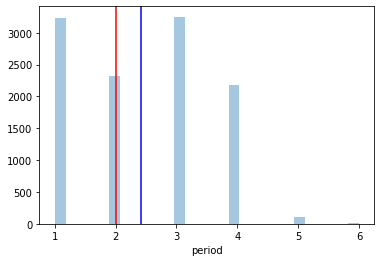

In [ ]:
import seaborn as sns
import matplotlib.pyplot as graph
from matplotlib import pyplot as plt
sns.distplot(train['period'], kde=False);
plt.axvline(train['period'].mean(), color='blue')
plt.axvline(train['period'].median(), color='red')

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
train['loc_y'].describe()

count   11,081
mean       129
std        101
min        -41
25%         23
50%        138
75%        214
max        811
Name: loc_y, dtype: float64

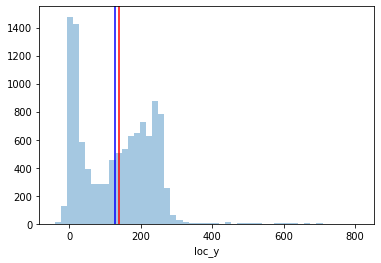

In [ ]:
sns.distplot(train['loc_y'], kde=False);
plt.axvline(train['loc_y'].mean(), color='blue')
plt.axvline(train['loc_y'].median(), color='red')

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
train['shot_distance'].describe()

count   11,081
mean        17
std         10
min          0
25%          8
50%         21
75%         25
max         83
Name: shot_distance, dtype: float64

In [ ]:
import numpy as np
def wrangle (X):
    """Wrangle train, validate, and test sets in the same way"""

    X = X.copy()

    X['shot_distance'] = np.where(X['shot_distance'].between(35,83), np.nan, X['shot_distance'])

    X['period'] = np.where(X['period'].between(5,6), np.nan, X['period'])

    X['loc_y'] = np.where(X['loc_y'].between(300,811), np.nan, X['loc_y'])

    X['loc_y'] = np.where(X['loc_y'].between(-41,0), np.nan, X['loc_y'])

    cols_with_zeros = ['minutes_remaining', 'seconds_remaining', 'shot_distance', 'loc_x', 'loc_y', 'scoremargin_before_shot']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    X = X.drop(columns=['minutes_remaining', 'seconds_remaining'])

    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [ ]:
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5916095890410958



## 7. Get your model's test accuracy

> (One time, at the end.)

In [ ]:
y_test = test[target]
print('test score:', pipeline.score(X_test, y_test))

test score: 0.620245757753072


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [ ]:
correct_predictions = 85 + 36 
correct_predictions

121

In [ ]:
total_predictions = 85 + 58 + 8 + 36
total_predictions

187

In [ ]:
accuracy_score = correct_predictions / total_predictions
accuracy_score


0.6470588235294118

### Calculate precision

In [ ]:
correct_predictions_positive = 36

In [ ]:
total_predictions_positive = 58 + 36

In [ ]:
correct_predictions_negative = 85

In [ ]:
total_predictions_negative = 85 +8

In [ ]:
precision_predictions_positive = correct_predictions_positive / total_predictions_positive
precision_predictions_positive

0.3870967741935484

In [ ]:
precision_predictions_negative = correct_predictions_negative/ total_predictions_negative
precision_predictions_negative

0.9139784946236559

### Calculate recall

In [ ]:
actual_positives = 8 + 36

In [ ]:
actual_negatives = 85 + 58

In [ ]:
recall_positives = correct_predictions_positive / actual_positives
recall_positives

0.8181818181818182

In [ ]:
recall_negatives = correct_predictions_negative / actual_negatives
recall_negatives

0.5944055944055944